In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
cuda = True

In [3]:
batch_size = 256

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(35),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
trainset = torchvision.datasets.FashionMNIST(
    root      = './data/', 
    train     = True,
    download  = True,
    transform = transform
)
trainloader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)
testset = torchvision.datasets.FashionMNIST(
    root      = './data/', 
    train     = False,
    download  = True,
    transform = transform
)
testloader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)
classes = (
    'top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'boot'
)

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
dataiter       = iter(trainloader)
images, labels = dataiter.next()

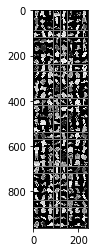

In [8]:
imshow(torchvision.utils.make_grid(images))

In [9]:
', '.join(classes[c] for c in labels)

'trouser, boot, trouser, bag, dress, trouser, sandal, dress, top, bag, sandal, coat, dress, sneaker, boot, pullover, dress, trouser, sneaker, sandal, dress, sandal, dress, shirt, boot, dress, coat, boot, coat, sneaker, dress, trouser, bag, bag, boot, trouser, sneaker, sandal, sneaker, dress, bag, pullover, sneaker, pullover, pullover, trouser, boot, trouser, sandal, bag, boot, coat, coat, pullover, boot, coat, bag, trouser, dress, sneaker, coat, trouser, sneaker, sneaker, shirt, top, shirt, bag, top, dress, sneaker, pullover, trouser, dress, top, sneaker, top, shirt, pullover, boot, bag, shirt, coat, trouser, dress, bag, shirt, sneaker, shirt, bag, sandal, pullover, sandal, top, trouser, sandal, dress, coat, top, boot, coat, bag, dress, boot, bag, shirt, boot, top, sneaker, trouser, coat, trouser, pullover, trouser, bag, shirt, bag, boot, top, sandal, trouser, sneaker, coat, shirt, sneaker, coat, trouser, sneaker, trouser, bag, trouser, boot, pullover, trouser, dress, trouser, boot, tr

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1  , 64 , 3, padding = 1)
        self.conv2 = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv3 = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv4 = nn.Conv2d(64 , 128 , 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding = 1)
        self.fc1   = nn.Linear(128 * 7 * 7, 512)
        self.fc2   = nn.Linear(512, 512)
        self.fc3   = nn.Linear(512, 512)
        self.fc4   = nn.Linear(512, 10)
        self.bn1   = nn.BatchNorm2d(64)
        self.bn2   = nn.BatchNorm2d(64)
        self.bn3   = nn.BatchNorm2d(64)
        self.bn4   = nn.BatchNorm2d(128)
        self.bn5   = nn.BatchNorm2d(128)
        self.bn6   = nn.BatchNorm2d(128)
        self.bn7   = nn.BatchNorm1d(512)
        self.bn8   = nn.BatchNorm1d(512)
        self.bn9   = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = F.dropout(F.relu(self.bn1(self.conv1(x))), 0.7)
        x = F.dropout(F.relu(self.bn2(self.conv2(x))), 0.7)
        x = F.dropout(F.relu(self.bn3(self.conv3(x))), 0.7)
        x = F.max_pool2d(x, (2, 2))
        x = F.dropout(F.relu(self.bn4(self.conv4(x))), 0.5)
        x = F.dropout(F.relu(self.bn5(self.conv5(x))), 0.5)
        x = F.dropout(F.relu(self.bn6(self.conv6(x))), 0.5)
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 128 * 7 * 7)
        x = F.dropout(F.relu(self.bn7(self.fc1(x))), 0.3)
        x = F.dropout(F.relu(self.bn8(self.fc2(x))), 0.3)
        x = F.dropout(F.relu(self.bn9(self.fc3(x))), 0.3)
        x = self.fc4(x)
        
        return x

In [11]:
cnn       = CNN().cuda() if cuda else CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())
epoch     = 30
print_int = 100

In [12]:
def validate_model(train = True):
    cnn.eval()
    total_loss            = 0.0
    total_prediction      = 0
    total_good_prediction = 0
    batch_number          = 0
    for X, y in trainloader if train else testloader:
        X, y = Variable(X), Variable(y)
        X, y = (X.cuda(), y.cuda()) if cuda else (X, y)

        y_pred                 = cnn(X)
        total_loss            += criterion(y_pred, y).data[0]
        total_prediction      += y_pred.size()[0]
        total_good_prediction += (y_pred.max(dim = 1)[1].data.cpu() == y.data.cpu()).sum()
        batch_number          += 1
    
    return total_loss / batch_number, 100 * total_good_prediction / total_prediction 

In [13]:
for i in range(epoch):
    running_loss = 0
    for j, (X_train, y_train) in enumerate(trainloader):
        cnn.train()
        X_train, y_train = Variable(X_train), Variable(y_train)
        X_train, y_train = (X_train.cuda(), y_train.cuda()) if cuda else (X_train, y_train)
        
        optimizer.zero_grad()
        y_pred = cnn(X_train)
        loss   = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        if j % print_int == 0:
            train_loss, train_acc = validate_model(True)
            val_loss, val_acc = validate_model(False)
            print(
                f'[{i + 1:<3}|{j:6}] running_loss: {running_loss.data[0] / (print_int if j != 0 else 1):.3f}, '
                f'train_loss: {train_loss:.5f}, '
                f'train_acc: {train_acc:.2f}% '
                f'val_loss: {val_loss:.5f}, '
                f'val_acc: {val_acc:.2f}%'
            )
            running_loss = 0

[1  |     0] running_loss: 2.337, train_loss: 2.30303, train_acc: 10.00% val_loss: 2.30266, val_acc: 10.00%
[1  |   100] running_loss: 0.600, train_loss: 0.72202, train_acc: 74.91% val_loss: 0.74201, val_acc: 74.37%
[1  |   200] running_loss: 0.413, train_loss: 0.37430, train_acc: 86.47% val_loss: 0.40313, val_acc: 85.54%
[2  |     0] running_loss: 0.459, train_loss: 0.40915, train_acc: 84.83% val_loss: 0.44199, val_acc: 83.76%
[2  |   100] running_loss: 0.343, train_loss: 0.31820, train_acc: 88.28% val_loss: 0.35467, val_acc: 87.24%
[2  |   200] running_loss: 0.325, train_loss: 0.31583, train_acc: 88.54% val_loss: 0.34954, val_acc: 87.10%
[3  |     0] running_loss: 0.303, train_loss: 0.35360, train_acc: 87.05% val_loss: 0.37174, val_acc: 86.13%
[3  |   100] running_loss: 0.292, train_loss: 0.29176, train_acc: 89.21% val_loss: 0.32255, val_acc: 88.19%
[3  |   200] running_loss: 0.291, train_loss: 0.26319, train_acc: 90.25% val_loss: 0.29876, val_acc: 88.92%
[4  |     0] running_loss: 0

[26 |   100] running_loss: 0.122, train_loss: 0.12021, train_acc: 95.48% val_loss: 0.23731, val_acc: 92.42%
[26 |   200] running_loss: 0.124, train_loss: 0.12686, train_acc: 95.23% val_loss: 0.22560, val_acc: 92.22%
[27 |     0] running_loss: 0.104, train_loss: 0.11333, train_acc: 95.78% val_loss: 0.22209, val_acc: 92.72%
[27 |   100] running_loss: 0.121, train_loss: 0.11810, train_acc: 95.58% val_loss: 0.21930, val_acc: 92.73%
[27 |   200] running_loss: 0.118, train_loss: 0.10842, train_acc: 96.00% val_loss: 0.20476, val_acc: 92.95%
[28 |     0] running_loss: 0.083, train_loss: 0.11513, train_acc: 95.63% val_loss: 0.21145, val_acc: 92.70%
[28 |   100] running_loss: 0.115, train_loss: 0.11202, train_acc: 95.83% val_loss: 0.22761, val_acc: 92.45%
[28 |   200] running_loss: 0.117, train_loss: 0.10537, train_acc: 96.16% val_loss: 0.21100, val_acc: 92.72%
[29 |     0] running_loss: 0.057, train_loss: 0.10481, train_acc: 96.07% val_loss: 0.21196, val_acc: 93.03%
[29 |   100] running_loss: 0